# MODEL 

Cargamos las librerias necesarias

In [1]:
from _utils import *
import pandas as pd

## Cargamos la data

In [2]:
df_1 = pd.read_json("./datasets/1_halving.json")
df_2 = pd.read_json("./datasets/2_halving.json")
df_3 = pd.read_json("./datasets/3_halving.json")
df_4 = pd.read_json("./datasets/4_halving.json")

## Preparamos la data

In [15]:
import numpy as np
from matplotlib import pyplot as plt


In [3]:
def get_series_by_coin(coin: str, df: pd.DataFrame):
    new_df = df.where(df["name"] == coin).dropna()
    return new_df

In [4]:
dataset = pd.concat([df_1,df_2,df_3,df_4])

In [6]:
df_bitcoin = get_series_by_coin("Bitcoin",dataset)
df_bitcoin.set_index("datetime", inplace=True)
df_bitcoin = df_bitcoin.sort_index()
df_bitcoin.head(5)

,id,serialId,symbol,name,slug,open,high,low,close,volume
datetime,,,,,,,,,,
2012-12-01 19:00:00,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,12.665000,12.679990,12.261722,12.500020,196673.627491
2012-12-02 19:00:00,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,12.490810,12.678990,12.320000,12.678990,398306.113232
2012-12-03 19:00:00,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,12.678990,13.499263,12.433030,13.409927,883930.986576
2012-12-04 19:00:00,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,13.400557,13.420000,12.700000,13.375447,436643.789962
2012-12-05 19:00:00,1e31218a-e44e-4285-820c-8282ee222035,6057.0,BTC,Bitcoin,bitcoin,13.300010,13.688800,12.908408,13.232808,677529.566308


In [7]:
#Variables for training
cols = list(df_bitcoin)[-1:4:-1]
#Date and volume columns are not used in training. 
print(cols) 

['volume', 'close', 'low', 'high', 'open']


Preparamos los datos para series de tiempo

In [10]:
# Función para generar las particiones preservando las características
# de la serie de tiempo
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df_bitcoin)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (907, 10)
Tamaño set de validación: (113, 10)
Tamaño set de prueba: (114, 10)


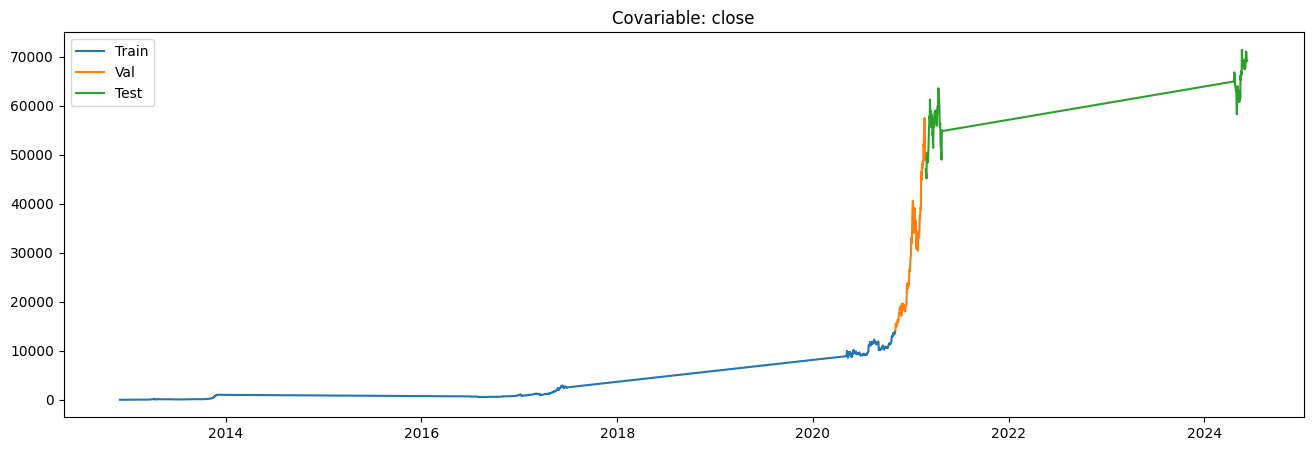

In [28]:
covar = 8 # Índice de la covariable (columna del dataset) a graficar
col = df_bitcoin.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

In [11]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [12]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 4    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (879, 24, 10), y_tr: (879, 4, 1)
Set de validación - x_vl: (85, 24, 10), y_vl: (85, 4, 1)
Set de prueba - x_ts: (86, 24, 10), y_ts: (86, 4, 1)


## Modelamos

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#New dataframe with only training data - 5 columns
df_for_training = df_bitcoin[cols].astype(float)

df_for_plot=df_for_training.tail(5000)
df_for_plot["close"].plot.line()

In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df_for_plot.index.values).to_list()
train_dates[:5]

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_training_scaled

In [ ]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

In [ ]:
# define the Autoencoder model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

In [ ]:
# Visualize train process
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq="1d").tolist()
print(predict_period_dates)

In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
print(y_pred_future)

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_pred_future})
df_forecast.set_index('date', inplace=True)

original = df_bitcoin[['open']]
original = original.loc[(original.index < '2024-06-08') & (original.index > '2023-05-24')]

sns.lineplot(original['open'])
sns.lineplot( df_forecast['open'])